Display the different models performance over each simulation

In [172]:
import os 
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

custom_params = {"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": False,
                 "axes.spines.bottom": False, "figure.dpi": 100}
sns.set_theme(style = "whitegrid", rc = custom_params, font_scale = 1.75)

In [173]:
path = 'results/'

In [174]:
# Naming for all 
models = {
    'correct': 'Correct', 
    'mm': 'LMM',
    'all': 'All', 
    'outcomes': r'Mis. $y$', 
    'sigma': r'Mis. $\omega$', 
    'nore': r'No $u^\omega$',
    'sigmanore': r'No $u^\omega$ + Mis. $\omega$',
    'melsm_notime': 'No slopes',
    'melsm_notimeomega': 'No $u^\omega_{age}$',
    'gaussian': 'Gaussian', 
    'nonsinus': 'Non sinus',
    'incorrect': r'Uncorrelated ($u^\omega$, $u^y$)'
    }

covariates = {
    # Covariates for mean
    'b_age': (r'$\beta^y[Age]$', 0.5),
    'b_albumin': (r'$\beta^y[Albumin]$', 0.5),
    'b_trig': (r'$\beta^y[Trig]$', 0),
    'b_platelet': (r'$\beta^y[Platelet]$', 0),

    'sd_id__Intercept': (r'$\sigma_{y}$', 1),

    # Covariates for variance
    'b_sigma_age': (r'$\beta^{\omega}[Age]$', 0.8),
    'b_sigma_albumin': (r'$\beta^{\omega}[Albumin]$', 0),
    'b_sigma_trig': (r'$\beta^{\omega}[Trig]$', 0.8),
    'b_sigma_platelet': (r'$\beta^{\omega}[Platelet]$', 0),

    'sd_id__sigma_Intercept': (r'$\sigma_{\omega}$', 0.5),
    'sd_id__sigma_age': (r'$\sigma_{\omega}[Age]$', 0.25)
    }

<>:11: SyntaxWarning: invalid escape sequence '\o'
<>:11: SyntaxWarning: invalid escape sequence '\o'
/var/folders/w9/b_zzkw291lzdn57dztyv6rrh0000gp/T/ipykernel_12576/1163588689.py:11: SyntaxWarning: invalid escape sequence '\o'
  'melsm_notimeomega': 'No $u^\omega_{age}$',


In [246]:
# Error to analyze
parameter = 'sd_id__sigma_Intercept'

In [247]:
naming, value = covariates[parameter]

In [248]:
def evaluate(path, param):
    print(path, ' - ', len(os.listdir(path)))

    estimates, ci, esterror, coverage = {}, {}, {}, {}

    # Evaluate by iterating across folder structure and averaging for each model types
    for replication in os.listdir(path):
        model_path = path + replication + '/'
        for model in os.listdir(model_path):
            if '.csv' not in model: continue

            csv_file = pd.read_csv(model_path + model, index_col = 0)
            model = models[model[:-4]] # Remove .csv extension
            if model not in estimates:
                estimates[model], ci[model], esterror[model], coverage[model] = [], [], [], []

            param_used = param
            if (param == 'b_age') and (param not in csv_file.index):
                # Special case for sinus
                param_used = 'b_sinage'
                
            if param_used in csv_file.index: 
                csv_file = csv_file.loc[param_used]            
                estimates[model].append(csv_file['Estimate'])
                ci[model].append(csv_file['Q97.5'] - csv_file['Q2.5'])
                esterror[model].append(csv_file['Est.Error'])
                coverage[model].append((csv_file['Q97.5'] > value) & (value > csv_file['Q2.5']))

    return estimates, ci, esterror, coverage

In [249]:
estimates, ci, esterror, coverage = {}, {}, {}, {}
for experiment in os.listdir(path):
    for number in os.listdir(path + experiment):
        # Check if directory
        if experiment in ['Individuals', 'Points', 'Correlated Random Effect']:
            estimates[(experiment, float(number))], ci[(experiment, float(number))], \
            esterror[(experiment, float(number))], coverage[(experiment, float(number))] = evaluate(path + experiment + '/' + number + '/', parameter)
        else:
            estimates[(experiment, -1)], ci[(experiment, -1)], \
            esterror[(experiment, -1)], coverage[(experiment, -1)] = evaluate(path + experiment + '/', parameter)
            break   

estimates, ci, esterror, coverage = pd.DataFrame(estimates), pd.DataFrame(ci), pd.DataFrame(esterror), pd.DataFrame(coverage)
estimates.index.name, ci.index.name, esterror.index.name, coverage.index.name = 'Models', 'Models', 'Models', 'Models'

results/Misspecification/  -  500
results/Random effect/  -  500
results/Individuals/300/  -  500
results/Individuals/100/  -  500
results/Individuals/500/  -  500
results/Individuals/1000/  -  500
results/Uncorrelated Data/  -  500
results/Time/  -  500
results/Correlated Random Effect/0.5/  -  500
results/Correlated Random Effect/0.9/  -  500
results/Points/20/  -  500
results/Points/10/  -  500
results/Points/5/  -  500
results/Sinus/  -  500


# Display tables

In [250]:
# Std of estimates
std_estimate = estimates.map(np.std)

/Users/vj2292/miniconda3/lib/python3.12/site-packages/numpy/_core/_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/vj2292/miniconda3/lib/python3.12/site-packages/numpy/_core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/vj2292/miniconda3/lib/python3.12/site-packages/numpy/_core/_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [251]:
# Average of std
average_error = esterror.map(np.mean)

/Users/vj2292/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/vj2292/miniconda3/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [252]:
# Average CI
average_ci = ci.map(np.mean)# .map(lambda x: '{:.2f} ({:.2f})'.format(np.mean(x), np.std(x)))

In [253]:
display = pd.concat({r'$SD$(' + naming + ')': std_estimate, 
                     r'$\bar{\epsilon}$(' + naming + ')': average_error, 
                     r'$\bar{CI}$(' + naming + ')': average_ci}, axis = 1)
display.columns = display.columns.reorder_levels([1, 2, 0])
display = display.sort_index(axis=1, level=[0, 1])

for experiment in display.columns.get_level_values(0).unique():
    save = display[experiment].dropna()
    if len(save.columns.get_level_values(0).unique()) == 1:
        save = save.droplevel(0, axis = 1)
    else:
        save = save.stack(level=0)
        save.index = save.index.reorder_levels([1, 0])
        save = save.sort_index()
    save = save.to_latex(float_format = '{:.3f}'.format, column_format='c' * (len(save.columns) + len(save.index.names)))
    save = re.sub(r'\\cline\{.*?\}', r'\\midrule', save)
    save = re.sub(r'\\multirow\[t\]', r'\\multirow[c]', save).replace('.000000', '').replace('00000', '')
    with open('images/{}/{}.tex'.format(experiment, parameter), 'w') as f:
        f.write(save)

/var/folders/w9/b_zzkw291lzdn57dztyv6rrh0000gp/T/ipykernel_12576/3486642765.py:12: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  save = save.stack(level=0)
/var/folders/w9/b_zzkw291lzdn57dztyv6rrh0000gp/T/ipykernel_12576/3486642765.py:12: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  save = save.stack(level=0)
/var/folders/w9/b_zzkw291lzdn57dztyv6rrh0000gp/T/ipykernel_12576/3486642765.py:12: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify f

# Displays error

/var/folders/w9/b_zzkw291lzdn57dztyv6rrh0000gp/T/ipykernel_12576/375565416.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(display, x = naming, y = "Models", order = order, hue = hue, color='tab:blue' if not hue else None,
/var/folders/w9/b_zzkw291lzdn57dztyv6rrh0000gp/T/ipykernel_12576/375565416.py:28: UserWarning: 
The palette list has fewer values (1) than needed (6) and will cycle, which may produce an uninterpretable plot.
  ax = sns.boxplot(display, x = naming, y = "Models", order = order, hue = hue, color='tab:blue' if not hue else None,
/Users/vj2292/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/vj2292/miniconda3/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value 

Misspecification


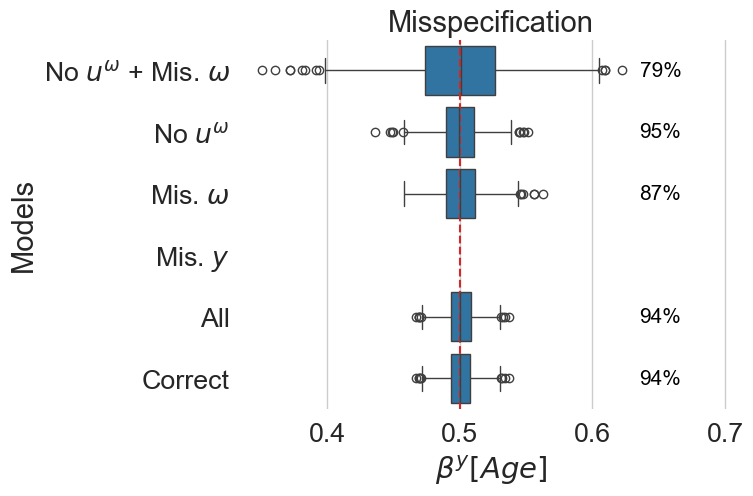

Random effect


/var/folders/w9/b_zzkw291lzdn57dztyv6rrh0000gp/T/ipykernel_12576/375565416.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(display, x = naming, y = "Models", order = order, hue = hue, color='tab:blue' if not hue else None,
/var/folders/w9/b_zzkw291lzdn57dztyv6rrh0000gp/T/ipykernel_12576/375565416.py:28: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  ax = sns.boxplot(display, x = naming, y = "Models", order = order, hue = hue, color='tab:blue' if not hue else None,


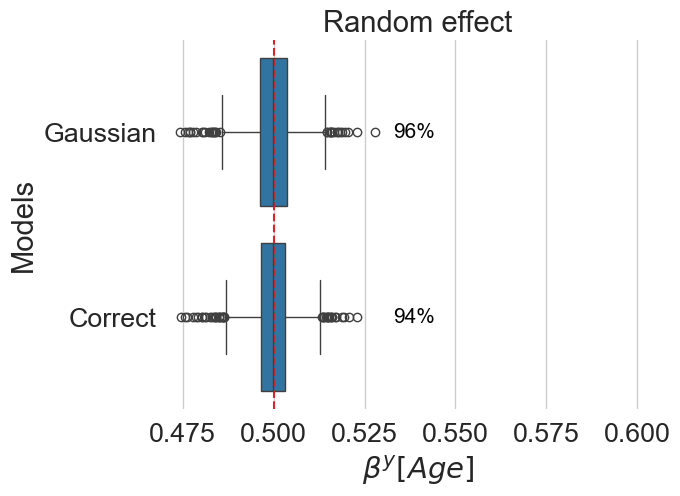

Individuals


/var/folders/w9/b_zzkw291lzdn57dztyv6rrh0000gp/T/ipykernel_12576/375565416.py:28: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.boxplot(display, x = naming, y = "Models", order = order, hue = hue, color='tab:blue' if not hue else None,


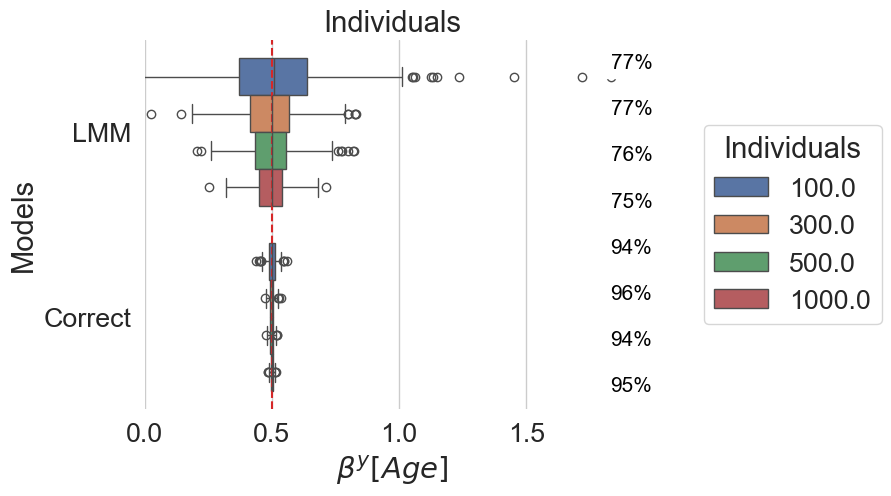

Uncorrelated Data


/var/folders/w9/b_zzkw291lzdn57dztyv6rrh0000gp/T/ipykernel_12576/375565416.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(display, x = naming, y = "Models", order = order, hue = hue, color='tab:blue' if not hue else None,
/var/folders/w9/b_zzkw291lzdn57dztyv6rrh0000gp/T/ipykernel_12576/375565416.py:28: UserWarning: 
The palette list has fewer values (1) than needed (6) and will cycle, which may produce an uninterpretable plot.
  ax = sns.boxplot(display, x = naming, y = "Models", order = order, hue = hue, color='tab:blue' if not hue else None,
/Users/vj2292/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/vj2292/miniconda3/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value 

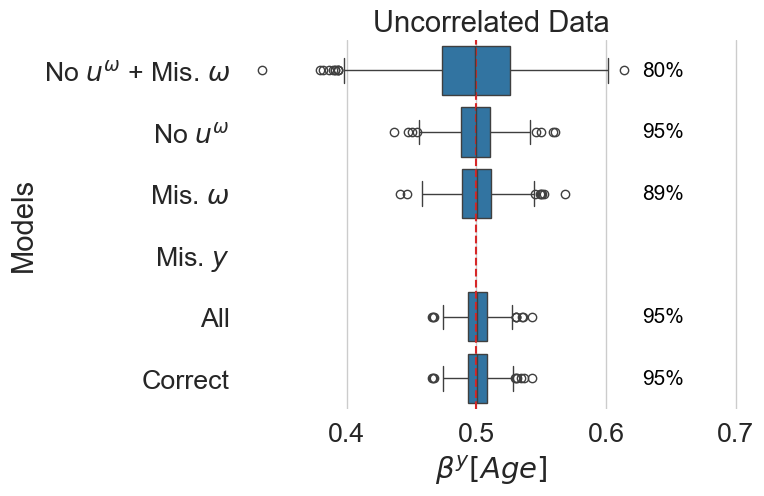

Time


/var/folders/w9/b_zzkw291lzdn57dztyv6rrh0000gp/T/ipykernel_12576/375565416.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(display, x = naming, y = "Models", order = order, hue = hue, color='tab:blue' if not hue else None,
/var/folders/w9/b_zzkw291lzdn57dztyv6rrh0000gp/T/ipykernel_12576/375565416.py:28: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  ax = sns.boxplot(display, x = naming, y = "Models", order = order, hue = hue, color='tab:blue' if not hue else None,


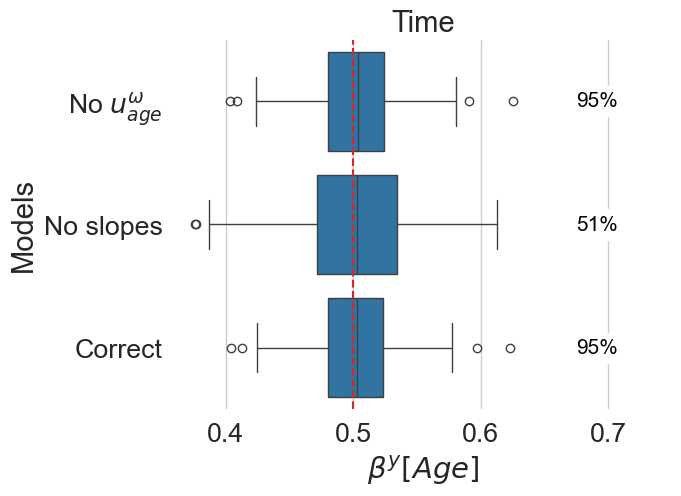

Correlated Random Effect


/var/folders/w9/b_zzkw291lzdn57dztyv6rrh0000gp/T/ipykernel_12576/375565416.py:28: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  ax = sns.boxplot(display, x = naming, y = "Models", order = order, hue = hue, color='tab:blue' if not hue else None,


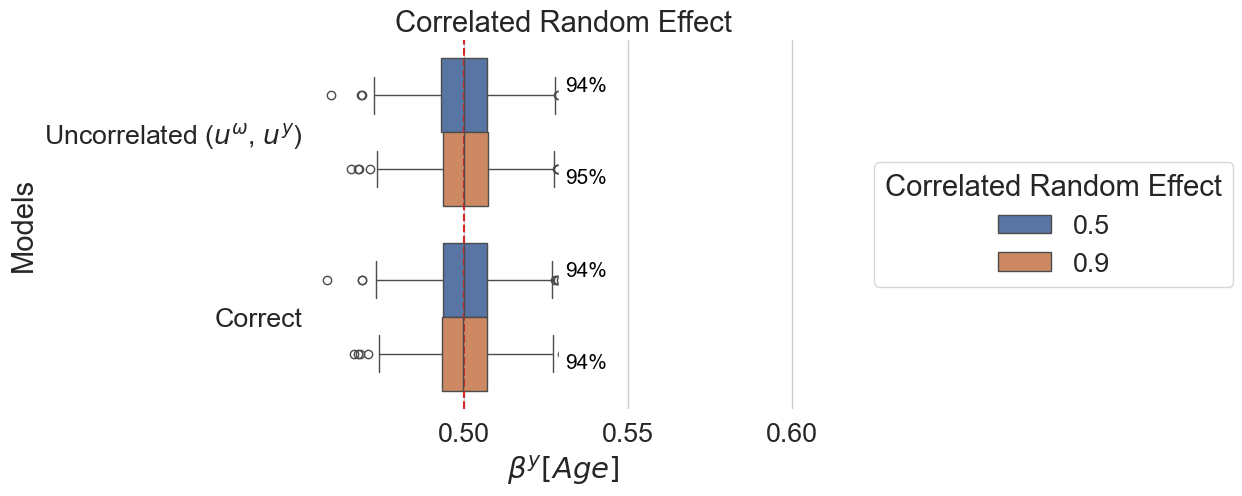

Points


/var/folders/w9/b_zzkw291lzdn57dztyv6rrh0000gp/T/ipykernel_12576/375565416.py:28: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax = sns.boxplot(display, x = naming, y = "Models", order = order, hue = hue, color='tab:blue' if not hue else None,


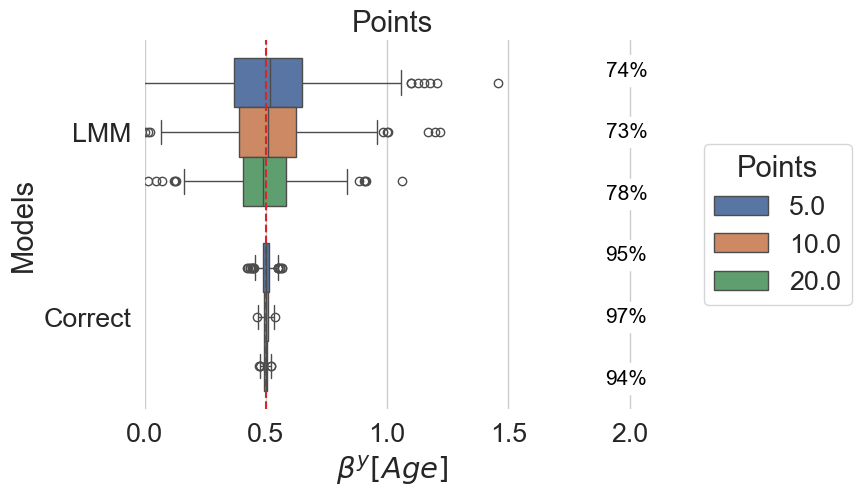

Sinus


/var/folders/w9/b_zzkw291lzdn57dztyv6rrh0000gp/T/ipykernel_12576/375565416.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(display, x = naming, y = "Models", order = order, hue = hue, color='tab:blue' if not hue else None,
/var/folders/w9/b_zzkw291lzdn57dztyv6rrh0000gp/T/ipykernel_12576/375565416.py:28: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  ax = sns.boxplot(display, x = naming, y = "Models", order = order, hue = hue, color='tab:blue' if not hue else None,


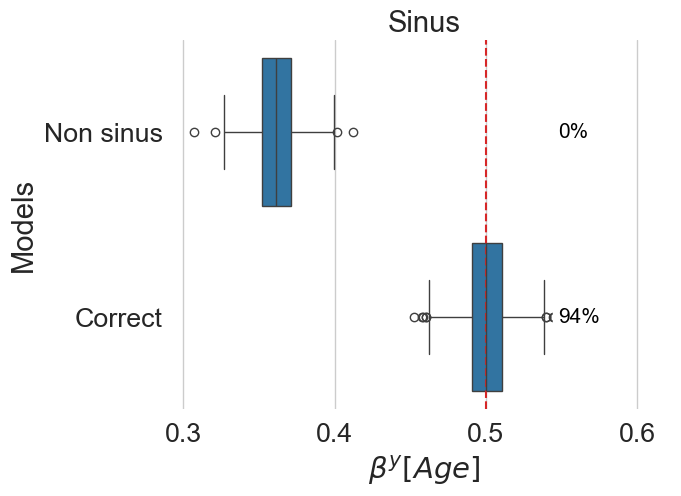

In [229]:
for simulation in estimates.columns.get_level_values(0).unique():
	print(simulation)
	shift = 0.025
	if (simulation == 'Individuals' or simulation == 'Points') and (parameter == 'b_age'):
		display = estimates[simulation]
	else:
		display = estimates[simulation][estimates.index != 'LMM']
		
	display = display.dropna()

	if len(display)	== 0:
		print(f'No data for {simulation}')
		continue

	order = [m for m in models.values() if m in display.index.unique()][::-1]
	hue = simulation if len(display.columns) > 1 else None

	# Transform in long format (do not repeat data, index is uninformative)
	if hue:
		columns = []
		for column in display.columns:
			columns.append(display[column].explode())
		display = pd.concat(columns, axis = 1).melt(var_name = hue, value_name = naming, ignore_index = False).reset_index()
	else:
		display = display.apply(pd.Series.explode).melt(var_name = simulation, value_name = naming, ignore_index = False).reset_index()
		display = display.drop(simulation, axis = 1)	

	ax = sns.boxplot(display, x = naming, y = "Models", order = order, hue = hue, color='tab:blue' if not hue else None, 
				     palette = sns.color_palette() if hue else ['tab:blue']) 

	yticks = ax.get_yticks()
	if simulation in display.columns:
		hue_values = display[simulation].unique()
		summary_values = display.groupby(["Models", simulation]).max()
		# Extract box positions
		box_positions = {}
		for i, m in enumerate(order):
			for j, h in enumerate(hue_values):
					offset = (j - (len(hue_values) - 1) / 2) / len(hue_values) # Adjust for hue groups
					box_positions[(m, h)] = yticks[i] + offset
	else:
		summary_values = display.groupby(["Models"]).max()
		# Extract box positions
		box_positions = {}
		for i, m in enumerate(order):
			box_positions[(m, -1)] = yticks[i] 

	# Annotate at the right end of each box
	for m, h in box_positions.keys():
		val = np.mean(coverage[simulation, h].loc[m])
		if ~np.isnan(val): 
			ax.text(min(display[naming].max(), 2.05), box_positions[(m, h)], f'{val:.0%}', ha='left',
					fontsize=15, va='center', color='black', 
					backgroundcolor='white')

	plt.xlim(max(0, ax.get_xlim()[0]), min(max(display[naming].max() + shift * 3, ax.get_xlim()[1]), 2.05 + shift * 3))
	plt.axvline(value, color = 'tab:red', linestyle = '--')
	if hue:
		plt.legend(title = simulation, loc='center left', bbox_to_anchor=(1.1, 0.5))

	plt.title(simulation)
	os.makedirs('images/{}'.format(simulation), exist_ok=True)
	plt.savefig('images/{}/{}.png'.format(simulation, parameter), bbox_inches='tight')
	plt.show()